Here we add the helper module

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

['1', '2'] class to dex  {'1': 0, '2': 1}
is cuda avaliable?  True
tensor(1)


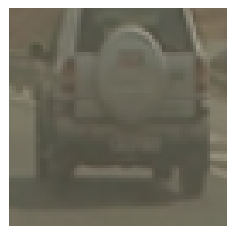

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os, random
import json
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import time
%matplotlib inline


data_dir = '/content/drive/My Drive/Hybrid'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), 
                                                           (0.5, 0.5, 0.5))
                                     ])

cost_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], 
                                                           [0.5, 0.5, 0.5])
                                     ])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5], 
                                                           [0.5, 0.5, 0.5])
                                     ])


# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir,transform=train_transforms)
cost_data = datasets.ImageFolder(valid_dir, transform=cost_transforms)
test_data  = datasets.ImageFolder(test_dir, transform=test_transforms)

# TODO: Using the image datasets and the transforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(cost_data, batch_size=64)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
print(train_data.classes,'class to dex ',train_data.class_to_idx)

image_datasets = [train_data, cost_data, test_data]
dataloaders = [train_loader, valid_loader, test_loader]

#check to see if cuda available
cuda = torch.cuda.is_available()
print('is cuda avaliable? ', cuda)

image,label=next(iter(train_loader))
imshow(image[0,:])
print(label[0])

loading models

In [0]:
input_size = 64*64*3 # 64 pixels and 3 channels RGB
hidden_sizes=[512,256,128]
output_size=2
model=nn.Sequential(nn.Linear(input_size,hidden_sizes[0]),
                    nn.ReLU(),
                    nn.Linear(hidden_sizes[0],hidden_sizes[1]),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(hidden_sizes[1],output_size),
                    nn.Softmax(dim=1))

print('model created.')
model

model created.


Sequential(
  (0): Linear(in_features=12288, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=256, out_features=2, bias=True)
  (6): Softmax(dim=1)
)

Train the classifier layers using backpropagation using the pre-trained network to get the features.

In [0]:
def validation(model1,testloader1,criterion1):
  test_loss=0
  accuracy = 0
  steps=0
  for images1,labels1 in testloader1:
    steps += 1
    #print('test step ',steps)
    images1.resize_(images1.size()[0],64*64*3)
    output=model1.forward(images1)
    test_loss += criterion1(output,labels1).item()
    # ps=probabilites. 
    ps=torch.exp(output)
    equality = (labels1.data==ps.max(dim=1)[1])
    accuracy += equality.type(torch.FloatTensor).mean()
  return test_loss,accuracy

In [0]:
optimizer=optim.SGD(model.parameters(),lr=0.006)
#optimizer=optim.Adam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()
#criterion=nn.NLLLoss()
epochs = 50
print_every = 10
running_loss=0
steps=0
current_accuracy=0
for e in range(epochs):
  model.train()
  for images,labels in iter(train_loader):
    steps += 1
    images.resize_(images.size()[0],64*64*3)
    #images = images.view(images.shape[0], -1) # resize an image
    optimizer.zero_grad()
    #forward and backward passes
    output = model.forward(images)
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    print(loss.item())
    #print('steps ',steps)
    if steps % print_every == 0:
      model.eval()
      '''with torch.no_grad():
        test_loss,accuracy =validation(model,test_loader,criterion)
      print("{:.3f}".format(accuracy/len(test_loader)))
      if (accuracy / len(test_loader)) > current_accuracy:
        current_accuracy = (accuracy/len(test_loader))
        # save the model
        torch.save(model.state_dict(),'checkpoint.pth') '''
      running_loss=0
      model.train()

0.6913086175918579
0.6945193409919739
0.6922103762626648
0.688808023929596
0.6898592114448547
0.6862356066703796
0.682101309299469
0.6858091950416565
0.6842710971832275
0.6796291470527649
0.6843907237052917
0.6755318641662598
0.6810311079025269
0.6769533753395081
0.67904132604599
0.6747387647628784
0.6813790202140808
0.6744885444641113
0.669093132019043
0.6773132681846619
0.681460976600647
0.6571629643440247
0.6752991080284119
0.6682955622673035
0.6788557171821594
0.6744346022605896
0.6603736281394958
0.6722139716148376
0.6650022864341736
0.6619940996170044
0.6633732318878174
0.6634868383407593
0.6540175676345825
0.6599903106689453
0.6485219597816467
0.6684361100196838
0.6454837918281555
0.6720831990242004
0.6572455763816833
0.6708562970161438
0.6583606004714966
0.6627221703529358
0.6535904407501221
0.6530278921127319
0.6670650839805603
0.6483882069587708
0.6546252369880676
0.6709840893745422
0.6457512974739075
0.6420269012451172
0.6421283483505249
0.661719560623169
0.6342259645462036


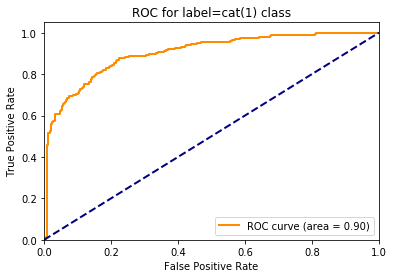

In [0]:
from sklearn import metrics
def test_class_probabilities(model, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for images, labels in test_loader:
            images.resize_(images.size()[0],64*64*3)
            output = model.forward(images)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(labels.view_as(prediction) == which_class)
            probabilities.extend(torch.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

which_class = 1 # with seatbelt (positive) images
actuals, class_probabilities = test_class_probabilities(model, test_loader, which_class)

fpr, tpr, _ = metrics.roc_curve(actuals, class_probabilities)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for label=cat(%d) class' % which_class)
plt.legend(loc="lower right")
plt.show()


In [0]:
#load the dictionary
state_dict=torch.load('checkpoint.pth')
model.load_state_dict(state_dict)

RuntimeError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


tensor(1)
probs  tensor([[0.2689, 0.7311]])


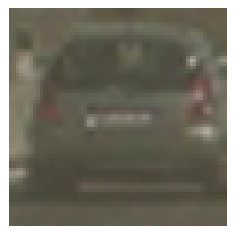

In [0]:
dataiter=iter(test_loader)
images,labels=dataiter.next()
print(labels[12])
img=images[12]
imshow(img)
img=img.resize_(1,64*64*3)
with torch.no_grad():
  logits=model.forward(img)
ps=F.softmax(logits,dim=1)
print('probs ',ps)
